***Mounting Drive***

<hr>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/'
path_models = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/models/'
sys.path.append(path)
sys.path.append(path_models)

***Loading the python files from drive***


In [0]:
# !pip install torch-lr-finder
!pip install -U albumentations
from imports_eva import *
import data_loaders as dl                         # Loading CIFAR10 data into train/test dataloaders
# import model_file as mfile                        # ResNet18 Model architecture
import train_test_functions as ttfunc             # Model training and validation functions
import test_performance as tperform               # Class wise model accuracy and confusion matrix plot
import model_plots as mp                          # Plotting the Train/Test plots for loss and accuracy
import resnet_modified_A11 as mdl
import misclassified                              # Display misclassified images by the trained model
from scheduler import *

     |████████████████████████████████| 122kB 7.6MB/s 
     |████████████████████████████████| 634kB 13.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=dedde8c1313b55a9587b765a32ecb6af7fae250fe9d64b70cab5574774658d35
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1a1f0bbd3445a4ca07f202e9aefffd0733b9878f00a397157aec89c77147d796
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


***Loading CIFAR data and creating test/train loaders with augumentations***
<hr>

In [0]:
trainloader, testloader = dl.train_test_loaders()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


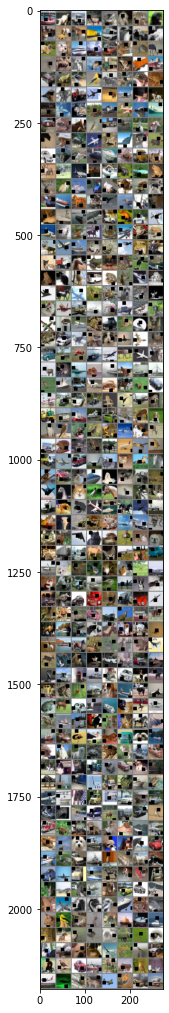

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

***Define the final target classes in CIFAR***


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

***Load RESNET18 model and print summary***
<hr>

In [0]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mdl.resnet_modified_A11().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        Dropout2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       BasicBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [0]:
EPOCHS = 50
# lrs = np.logspace(-2, 0, 100)
lrs = np.linspace(1e-4, 1, EPOCHS)
mtms = np.linspace(0.9, 0.9, EPOCHS)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = ListScheduler(optimizer, lrs=lrs, momentums=mtms)

model = mdl.resnet_modified_A11().to(device)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer.param_groups]
    current_m = [g['momentum'] for g in optimizer.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    ta, tl, ta_epoch, tl_epoch   =  ttfunc.train(model, device, trainloader, optimizer, epoch)
    ta1, tl1 =  ttfunc.test(model, device, testloader, classes)
    scheduler.step()
    print('')


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.0001], M : [0.0]


Loss=2.9369115829467773 Batch_id=97 Accuracy=10.67: 100%|██████████| 98/98 [00:18<00:00,  5.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 997/10000 (9.97%)


EPOCH: 2
LR: [0.02050612244897959], M : [0.0]


Loss=2.9569926261901855 Batch_id=97 Accuracy=10.45: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1000/10000 (10.00%)


EPOCH: 3
LR: [0.04091224489795919], M : [0.0]


Loss=3.022020101547241 Batch_id=97 Accuracy=10.75: 100%|██████████| 98/98 [00:18<00:00,  5.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1005/10000 (10.05%)


EPOCH: 4
LR: [0.061318367346938775], M : [0.0]


Loss=2.983766555786133 Batch_id=97 Accuracy=10.29: 100%|██████████| 98/98 [00:18<00:00,  5.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1008/10000 (10.08%)


EPOCH: 5
LR: [0.08172448979591837], M : [0.0]


Loss=3.112109661102295 Batch_id=97 Accuracy=10.38: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1001/10000 (10.01%)


EPOCH: 6
LR: [0.10213061224489794], M : [0.0]


Loss=3.010969877243042 Batch_id=97 Accuracy=10.32: 100%|██████████| 98/98 [00:18<00:00,  5.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1008/10000 (10.08%)


EPOCH: 7
LR: [0.12253673469387756], M : [0.0]


Loss=2.8415586948394775 Batch_id=97 Accuracy=10.26: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 998/10000 (9.98%)


EPOCH: 8
LR: [0.14294285714285712], M : [0.0]


Loss=3.0824363231658936 Batch_id=97 Accuracy=10.43: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 990/10000 (9.90%)


EPOCH: 9
LR: [0.16334897959183672], M : [0.0]


Loss=3.0788302421569824 Batch_id=97 Accuracy=10.44: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1003/10000 (10.03%)


EPOCH: 10
LR: [0.18375510204081633], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1002/10000 (10.02%)


EPOCH: 11
LR: [0.2041612244897959], M : [0.0]


Loss=3.060816526412964 Batch_id=97 Accuracy=10.38: 100%|██████████| 98/98 [00:18<00:00,  5.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1006/10000 (10.06%)


EPOCH: 12
LR: [0.2245673469387755], M : [0.0]


Loss=2.9678561687469482 Batch_id=97 Accuracy=10.51: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 998/10000 (9.98%)


EPOCH: 13
LR: [0.2449734693877551], M : [0.0]


Loss=3.009129285812378 Batch_id=11 Accuracy=10.69:  11%|█         | 11/98 [00:02<00:16,  5.17it/s]

In [0]:
max_lr = lrs[ta_epoch.index(max(ta_epoch))]
min_lr = max_lr/10
print(max(ta_epoch))
print(ta_epoch.index(max(ta_epoch)))
print(lrs[ta_epoch.index(max(ta_epoch))])
print(lrs[ta_epoch.index(max(ta_epoch))]/10)
ta_epoch



11.066
15
0.7894737052631579
0.07894737052631579


[10.028,
 9.914,
 10.228,
 9.784,
 10.68,
 9.99,
 10.178,
 10.492,
 10.43,
 8.728,
 9.352,
 10.396,
 10.05,
 9.894,
 10.034,
 11.066,
 10.506,
 10.048,
 9.912,
 10.146]

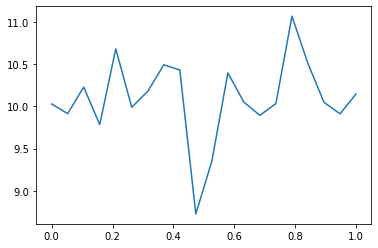

In [0]:
plt.plot(lrs,ta_epoch)

In [0]:
lr_s = np.interp(np.arange(24), [0, 4, 23, 24], [0.0157, 0.157, 0.0157, 0])
# lr_s = np.interp(np.arange(24), [0, 4, 23, 24], [0.0526, 0.526, 0.0526, 0])
# lr_s = np.interp(np.arange(24), [0, 4, 23, 24], [min_lr, max_lr, min_lr, 0])
mtm_s = np.interp(np.arange(24), [0, 4, 23, 24], [0.95, 0.8, 0.95, 0.95])

print(lr_s)
print(mtm_s)

[0.0157     0.051025   0.08635    0.121675   0.157      0.14956316
 0.14212632 0.13468947 0.12725263 0.11981579 0.11237895 0.10494211
 0.09750526 0.09006842 0.08263158 0.07519474 0.06775789 0.06032105
 0.05288421 0.04544737 0.03801053 0.03057368 0.02313684 0.0157    ]
[0.95       0.9125     0.875      0.8375     0.8        0.80789474
 0.81578947 0.82368421 0.83157895 0.83947368 0.84736842 0.85526316
 0.86315789 0.87105263 0.87894737 0.88684211 0.89473684 0.90263158
 0.91052632 0.91842105 0.92631579 0.93421053 0.94210526 0.95      ]


***Model Training***
---
<hr>

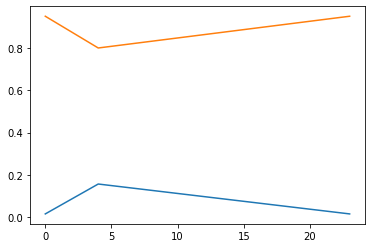

In [0]:
plt.plot(np.arange(24),lr_s)
plt.plot(np.arange(24),mtm_s)

In [0]:
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
train_acc = []
train_loss = []
val_acc = []
val_loss = []


# model1 =  mfile.resnet18().to(device)
model1 =  mdl.resnet_modified_A11().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum = 0.9, weight_decay=0.001)
scheduler1 = ListScheduler(optimizer1, lrs=lr_s, momentums=mtm_s)
EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer1.param_groups]
    current_m = [g['momentum'] for g in optimizer1.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    tr_ac_batch, tr_ls_batch, tr_ac_epoch, tr_ls_epoch   =  ttfunc.train(model1, device, trainloader, optimizer1, epoch)
    ts_ac, ts_ls =  ttfunc.test(model1, device, testloader, classes)
    scheduler1.step()
    print('')


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.0157], M : [0.9500000000000001]


Loss=2.583657741546631 Batch_id=97 Accuracy=12.60: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 1583/10000 (15.83%)


EPOCH: 2
LR: [0.051025], M : [0.9125]


Loss=4.166126728057861 Batch_id=97 Accuracy=22.27: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 2666/10000 (26.66%)


EPOCH: 3
LR: [0.08635000000000001], M : [0.875]


Loss=2.6135990619659424 Batch_id=97 Accuracy=27.16: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 3393/10000 (33.93%)


EPOCH: 4
LR: [0.121675], M : [0.8375]


Loss=1.712868332862854 Batch_id=97 Accuracy=35.69: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4419/10000 (44.19%)


EPOCH: 5
LR: [0.157], M : [0.8]


Loss=1.4527246952056885 Batch_id=97 Accuracy=44.58: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5630/10000 (56.30%)


EPOCH: 6
LR: [0.14956315789473684], M : [0.8078947368421053]


Loss=1.276489496231079 Batch_id=97 Accuracy=53.75: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6197/10000 (61.97%)


EPOCH: 7
LR: [0.14212631578947368], M : [0.8157894736842105]


Loss=1.0108896493911743 Batch_id=97 Accuracy=61.38: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6548/10000 (65.48%)


EPOCH: 8
LR: [0.13468947368421053], M : [0.8236842105263158]


Loss=0.8660224676132202 Batch_id=97 Accuracy=66.86: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7227/10000 (72.27%)


EPOCH: 9
LR: [0.12725263157894737], M : [0.8315789473684211]


Loss=0.7476513981819153 Batch_id=97 Accuracy=71.11: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7593/10000 (75.93%)


EPOCH: 10
LR: [0.11981578947368421], M : [0.8394736842105264]


Loss=0.806189775466919 Batch_id=97 Accuracy=74.17: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7732/10000 (77.32%)


EPOCH: 11
LR: [0.11237894736842105], M : [0.8473684210526315]


Loss=0.6486853361129761 Batch_id=97 Accuracy=76.55: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8141/10000 (81.41%)


EPOCH: 12
LR: [0.10494210526315789], M : [0.8552631578947368]


Loss=0.7142148613929749 Batch_id=97 Accuracy=78.14: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8104/10000 (81.04%)


EPOCH: 13
LR: [0.09750526315789473], M : [0.8631578947368421]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8224/10000 (82.24%)


EPOCH: 14
LR: [0.09006842105263158], M : [0.8710526315789474]


Loss=0.4945242404937744 Batch_id=97 Accuracy=81.37: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8489/10000 (84.89%)


EPOCH: 15
LR: [0.08263157894736842], M : [0.8789473684210526]


Loss=0.4414375424385071 Batch_id=97 Accuracy=82.73: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8370/10000 (83.70%)


EPOCH: 16
LR: [0.07519473684210526], M : [0.8868421052631579]


Loss=0.4413408637046814 Batch_id=97 Accuracy=83.48: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8652/10000 (86.52%)


EPOCH: 17
LR: [0.0677578947368421], M : [0.8947368421052632]


Loss=0.48129358887672424 Batch_id=97 Accuracy=84.96: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8673/10000 (86.73%)


EPOCH: 18
LR: [0.06032105263157894], M : [0.9026315789473686]


Loss=0.39693573117256165 Batch_id=97 Accuracy=85.63: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8719/10000 (87.19%)


EPOCH: 19
LR: [0.052884210526315784], M : [0.9105263157894736]


Loss=0.4074959456920624 Batch_id=97 Accuracy=86.24: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8812/10000 (88.12%)


EPOCH: 20
LR: [0.045447368421052625], M : [0.9184210526315789]


Loss=0.39281949400901794 Batch_id=97 Accuracy=87.12: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8753/10000 (87.53%)


EPOCH: 21
LR: [0.03801052631578947], M : [0.9263157894736842]


Loss=0.33538058400154114 Batch_id=97 Accuracy=87.74: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8897/10000 (88.97%)


EPOCH: 22
LR: [0.03057368421052631], M : [0.9342105263157895]


Loss=0.27865177392959595 Batch_id=97 Accuracy=88.33: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9004/10000 (90.04%)


EPOCH: 23
LR: [0.02313684210526315], M : [0.9421052631578948]


Loss=0.2939189374446869 Batch_id=97 Accuracy=89.59: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9012/10000 (90.12%)


EPOCH: 24
LR: [0.0157], M : [0.9500000000000001]


Loss=0.27296972274780273 Batch_id=97 Accuracy=90.35: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]



Test set: Average loss: 0.0006, Accuracy: 9041/10000 (90.41%)




In [0]:
model

ResNet1(
  (d): Dropout2d(p=0.1, inplace=False)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (d1): Dropout2d(p=0.1, inplace=False)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): Conv2d(128, 256, kernel_

**Cyclic LR pattern**

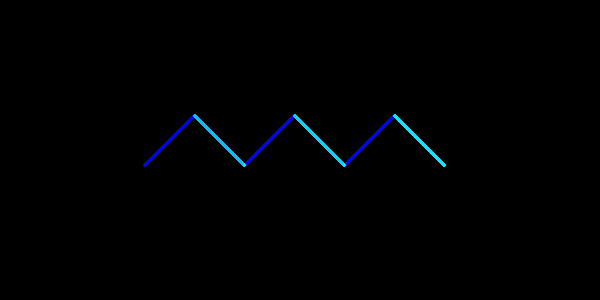

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def draw_cyclicLR(x,y):
  img = np.zeros((300,600,3), np.uint8)
  imgs = []
  for i in range(3):
    img1 = cv2.line(img,(x,y),(x+50,y-50),(255,0,0),2)
    img2 = cv2.line(img,(x+50,y-50),(x+100,y),(255,245,0),2)
    x = x + 100
    imgs.append(img1+img2)
  cv2_imshow(sum(imgs))

#range from 0 to 300 can be tried for object to be in box
draw_cyclicLR(144,165)

***Checking test data performance/results***
<hr>

------------------------------------------------------------
Model accuracy on 10000 test images: 90.41%
------------------------------------------------------------
 
Category   - Accuracy
plane      - 90.30
car        - 96.70
bird       - 89.20
cat        - 67.50
deer       - 91.20
dog        - 91.10
frog       - 95.80
horse      - 92.50
ship       - 95.00
truck      - 94.80
 


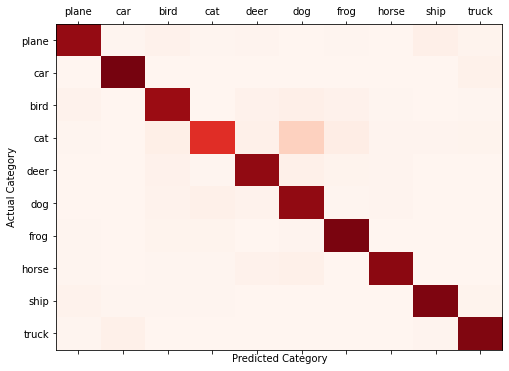

In [0]:
tperform.test_performance(model1, testloader, device, classes)

***Show misclassified TEST images***
<hr>

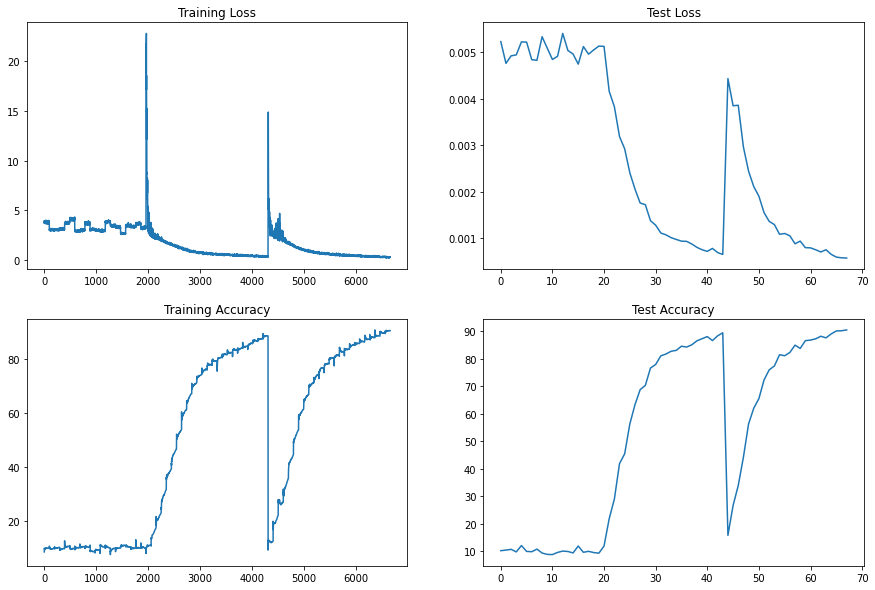

In [0]:
mp.train_testplots(trainloss = tr_ls_batch , trainacc = tr_ac_batch, testloss = ts_ls , testacc = ts_ac)

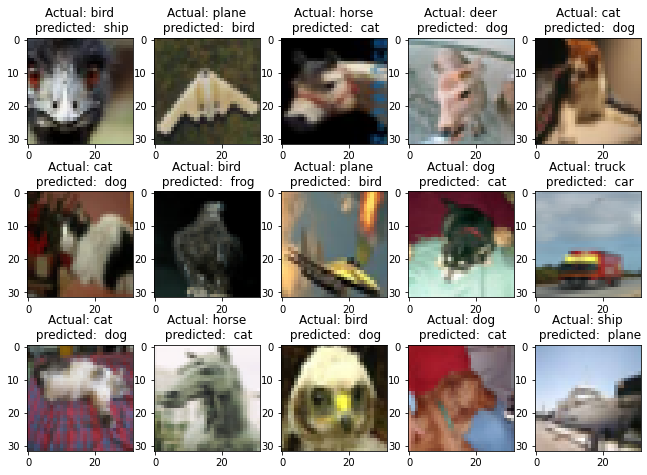

In [0]:
images, actuals, preds = misclassified.test_misclassified(model1,device,testloader)
misclassified.plot_images(images, actuals, preds, classes)